<a href="https://colab.research.google.com/github/georevge/Real_Fake_face/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ANN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
base_dir = '/content/drive/MyDrive/real_and_fake_face/'
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation ,Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy


from sklearn.preprocessing import MinMaxScaler
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator


import cv2

In [ ]:
val_folder=[val_dir+'/fake',val_dir+'/real']
train_folder=[train_dir+'/fake',train_dir+'/real']

def get_data(folders):
            images = []
            for folder in folders:
              for filename in os.listdir(folder):
                  img = cv2.imread(os.path.join(folder,filename))
                  res_img = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
                  norm = cv2.normalize(res_img, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)#res_img
                  if img is not None:
                    images.append(norm)#norm
            return images

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
model = Sequential()

model.add(Dense(256,input_shape=(67500,),activation='relu'))
#model.add(BatchNormalization())

model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))
#model.add(BatchNormalization())

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 256)               17280256  
_________________________________________________________________
dense_98 (Dense)             (None, 1024)              263168    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_99 (Dense)             (None, 64)                65600     
_________________________________________________________________
dense_100 (Dense)            (None, 2)                 130       
Total params: 17,609,154
Trainable params: 17,609,154
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train=get_data(train_folder)

In [ ]:
X_val=get_data(val_folder)

In [ ]:
X_train=np.array(X_train)
X_train =X_train.reshape(X_train.shape[0],67500).astype('float32')#196608
y_train=np.ones(1536)
y_train[0:768]=0


X_val=np.array(X_val)
X_val=X_val.reshape(X_val.shape[0],67500).astype('float32')
y_val=np.ones(384)
y_val[0:192]=0



In [ ]:
#Compile
from keras.optimizers import SGD
opt=Adam(lr=0.00001)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                       mode ="min", patience = 5,
                                      restore_best_weights = True)
history=model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), shuffle=True, verbose=2, callbacks =[earlystopping])

Epoch 1/20
24/24 - 3s - loss: 0.6868 - accuracy: 0.5573 - val_loss: 0.6444 - val_accuracy: 0.6328
Epoch 2/20
24/24 - 3s - loss: 0.6027 - accuracy: 0.6842 - val_loss: 0.6591 - val_accuracy: 0.6484
Epoch 3/20
24/24 - 3s - loss: 0.5523 - accuracy: 0.7383 - val_loss: 0.6361 - val_accuracy: 0.6406
Epoch 4/20
24/24 - 3s - loss: 0.4950 - accuracy: 0.8092 - val_loss: 0.6271 - val_accuracy: 0.6406
Epoch 5/20
24/24 - 3s - loss: 0.4436 - accuracy: 0.8509 - val_loss: 0.6299 - val_accuracy: 0.6406
Epoch 6/20
24/24 - 3s - loss: 0.4049 - accuracy: 0.8757 - val_loss: 0.6437 - val_accuracy: 0.6432
Epoch 7/20
24/24 - 3s - loss: 0.3700 - accuracy: 0.9036 - val_loss: 0.6482 - val_accuracy: 0.6406
Epoch 8/20
24/24 - 3s - loss: 0.3354 - accuracy: 0.9199 - val_loss: 0.6549 - val_accuracy: 0.6432
Epoch 9/20
24/24 - 3s - loss: 0.2965 - accuracy: 0.9479 - val_loss: 0.6704 - val_accuracy: 0.6224


In [ ]:
score = model.evaluate(X_val,y_val)
print('Test score: ', score[0])
print('Test accuracy: ', score[1])

12/12 [==============================] - 0s 24ms/step - loss: 0.6271 - accuracy: 0.6406
Test score:  0.6270675659179688
Test accuracy:  0.640625


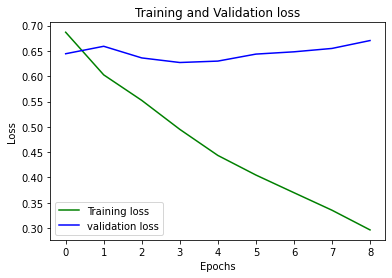

In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,9)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

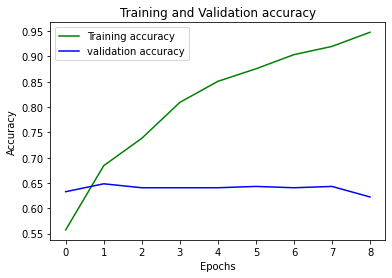

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,9)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Confusion Matrix
%matplotlib inline
from sklearn.metrics import confusion_matrix

import itertools
import matplotlib.pyplot as plt

predictions=model.predict(x=X_val, batch_size=128, verbose=0)
rounded_predictions=np.argmax(predictions, axis=-1)

cm=confusion_matrix(y_true=y_val, y_pred=rounded_predictions)

def plot_colfusion_matrix(cm,classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
      cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
    else:
      print("Confusion matrix, without normalization")

    print(cm)
    thresh= cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[0])):
      plt.text(j, i, cm[i, j],
               horizontalalignment="center",
               color="red" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[119  73]
 [ 65 127]]


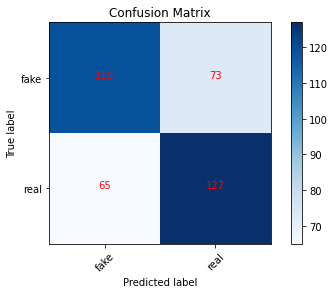

In [ ]:
cm_plot_labels=['fake', 'real']
plot_colfusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn import metrics
precisions, recall, f1_score, samples_per_class = metrics.precision_recall_fscore_support(y_val, rounded_predictions,labels = [0,1])
print('Precision :',precisions,'\nRecall :',recall,'\nF1_Score :',f1_score,'\nSamples per class :',samples_per_class)

Precision : [0.64673913 0.635     ] 
Recall : [0.61979167 0.66145833] 
F1_Score : [0.63297872 0.64795918] 
Samples per class : [192 192]
